# Dikemodel continued - subspace partitioning

Scenario discovery.... (nog uitleg toevoegen)

## 1. Apply scenario discovery

**1.** Import model from Open Exploration

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [42]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation2 import get_model_for_problem_formulation, sum_over, sum_over_time

**2.** Import results from Open Exploration

bla bla importeren en levers weghalen



In [43]:
from ema_workbench import load_results

# Laad de resultaten
results = load_results('dike_open_exploration_results.tar.gz')
#results = load_results("dike_open_exploration_with_allcosts.tar.gz")
experiments, outcomes = results


lever_columns = [
    '0_RfR 0', '0_RfR 1', '0_RfR 2',
    '1_RfR 0', '1_RfR 1', '1_RfR 2',
    '2_RfR 0', '2_RfR 1', '2_RfR 2',
    '3_RfR 0', '3_RfR 1', '3_RfR 2',
    '4_RfR 0', '4_RfR 1', '4_RfR 2',
    'EWS_DaysToThreat',
    'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
    'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
    'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
    'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
    'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'
]

cleaned_experiments = experiments.drop(columns=lever_columns)

In [44]:
cleaned_experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,scenario,policy,model
0,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,0.473504,263.739930,1.0,0.715619,4.5,2.5,2.5,850,575,dikesnet
1,98,49.027480,1.0,0.417407,253.026000,10.0,0.728410,283.784676,1.5,0.810960,...,0.911483,244.987697,1.5,0.597975,3.5,2.5,1.5,851,575,dikesnet
2,13,95.654535,1.5,0.258603,273.202696,10.0,0.661678,109.675534,10.0,0.858289,...,0.368582,99.077974,1.0,0.659313,1.5,3.5,4.5,852,575,dikesnet
3,30,121.315253,1.5,0.182422,302.958332,10.0,0.329761,303.433050,10.0,0.604211,...,0.087925,165.214010,1.0,0.305738,4.5,1.5,1.5,853,575,dikesnet
4,40,319.527238,1.5,0.125212,164.655619,1.5,0.119462,37.691628,1.5,0.610609,...,0.874862,129.450559,10.0,0.678432,4.5,2.5,4.5,854,575,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,115,201.886942,1.5,0.870114,270.963740,1.0,0.209037,67.443082,1.5,0.278408,...,0.305040,328.175211,10.0,0.639298,1.5,2.5,1.5,945,849,dikesnet
27496,123,44.315580,10.0,0.567903,63.787900,1.5,0.978183,155.291294,1.0,0.915425,...,0.794625,243.987996,1.0,0.766928,4.5,3.5,3.5,946,849,dikesnet
27497,2,242.351563,1.0,0.614782,234.032906,1.5,0.029254,160.733997,10.0,0.491912,...,0.945212,33.918258,10.0,0.104930,2.5,3.5,3.5,947,849,dikesnet
27498,84,306.378082,1.0,0.276462,293.870747,10.0,0.396654,49.056425,10.0,0.440742,...,0.337226,304.095851,1.0,0.313537,4.5,1.5,3.5,948,849,dikesnet


**3.** Apply scenario discovery

neem de data die onder de 36970.... aan kosten is, doe daar een prim analyse op. je krijgt leuk plaatje

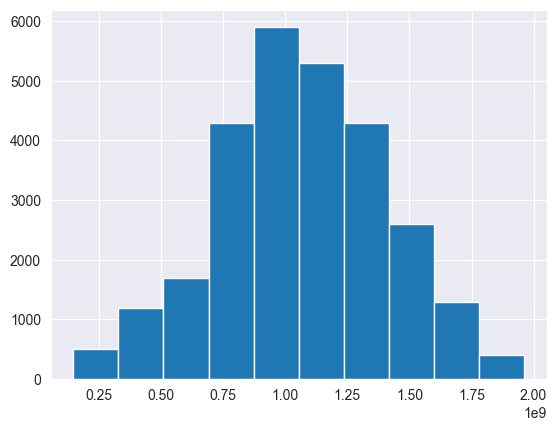

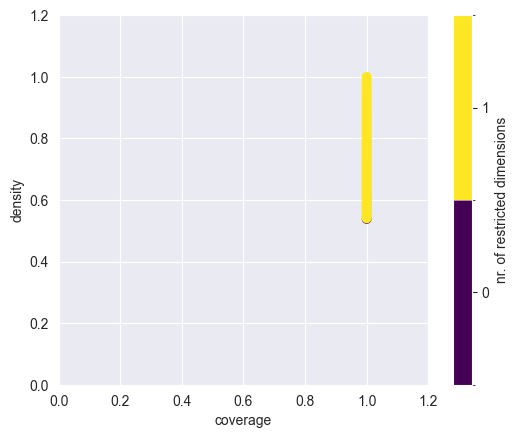

In [53]:
from ema_workbench.analysis import prim
import numpy as np

# Stel een vulnerability-condition in op basis van een relevante outcome
data_rfrtotalcost = outcomes['RfR Total Costs']
# y = data > np.percentile(data, 90)
#y_rfrtotalcost = (data_rfrtotalcost <= 1250000000).astype(bool)
y_rfrtotalcost = ((data_rfrtotalcost >= 1000000000) & (data_rfrtotalcost <= 1750000000)).astype(bool)

#y_rfrtotalcost = ((data_rfrtotalcost >= 250000000) & (data_rfrtotalcost <= 1250000000)).astype(bool)

#y = (data < np.percentile(data, 10)).astype(int)  # of .astype(bool)
plt.hist(data_rfrtotalcost )
# PRIM-analyse
#prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, mode='BINARY')  # expliciet maken

prim_alg_rfrtotalcost = prim.Prim(cleaned_experiments, y_rfrtotalcost, threshold=0.8)
box_rfrtotalcost = prim_alg_rfrtotalcost.find_box()
box_rfrtotalcost.show_tradeoff()
plt.show()


In [46]:
print("Aantal cases of interest:", np.sum(y_rfrtotalcost))

Aantal cases of interest: 18900


coverage        1.000000
density         1.000000
id             86.000000
k           18900.000000
mass            0.687273
mean            1.000000
n           18900.000000
res_dim         1.000000
Name: 86, dtype: float64

                                                   box 86  \
                                                      min   
policy  {575, 576, 579, 582, 583, 586, 588, 589, 590, ...   

                                                                             
                                                      max qp value qp value  
policy  {575, 576, 579, 582, 583, 586, 588, 589, 590, ...      0.0      NaN  



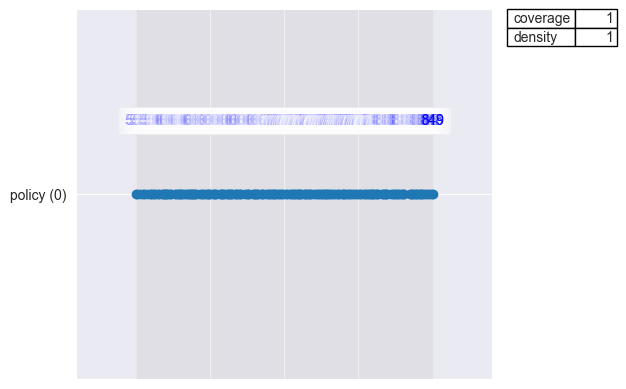

In [47]:
box_rfrtotalcost.inspect()
box_rfrtotalcost.inspect(style='graph')
plt.show()

In [48]:
x = cleaned_experiments.reset_index(drop=True)
# Boolean array van experimenten in de box
in_box_rfrtotalcost = box_rfrtotalcost.yi  # Deze is altijd even lang als x na reset_index

# Selecteer de experimenten die in de box vallen
experiments_in_box_rfrtotalcost = x.loc[in_box_rfrtotalcost]

# Unieke policies selecteren
robust_policies_rfrtotalcost = experiments_in_box_rfrtotalcost['policy'].unique()

# Robuuste policies opzoeken in originele experimenten
robust_policies_df_rfrtotalcost = experiments[experiments['policy'].isin(robust_policies_rfrtotalcost)].drop_duplicates(subset='policy')

# Toon resultaat
print("Robust Policies for RfR Total Costs:")
display(robust_policies_df_rfrtotalcost)


Robust Policies for RfR Total Costs:


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,6,5,6,3,4,1,3,850,575,dikesnet
100,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,8,10,6,5,7,0,1,850,576,dikesnet
400,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,2,7,9,1,1,8,3,850,579,dikesnet
700,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,2,7,1,1,5,7,4,850,582,dikesnet
800,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,5,7,3,1,1,4,0,850,583,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26800,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,0,0,3,2,9,1,3,850,843,dikesnet
27000,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,1,4,5,0,3,4,2,850,845,dikesnet
27200,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,5,8,3,4,9,5,0,850,847,dikesnet
27300,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,9,9,5,1,4,4,2,850,848,dikesnet


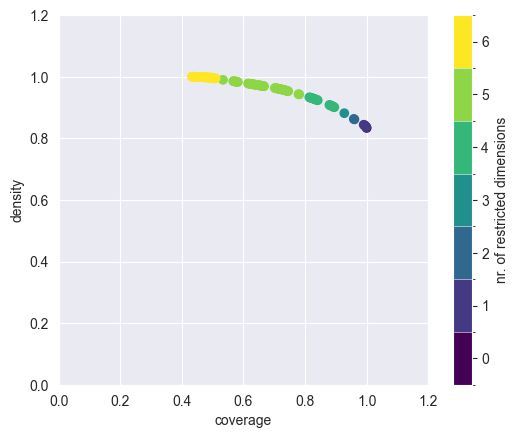

In [49]:
# Stel een vulnerability-condition in op basis van een relevante outcome
data_expanndamage = outcomes['Expected Annual Damage']
# y = data > np.percentile(data, 90)
# y_expanndamage = (data_expanndamage <= 369700000).astype(bool)
#y_expanndamage = (data_expanndamage <= 100000000).astype(bool)
y_expanndamage = (data_expanndamage <= 50000000).astype(bool)
#y = (data < np.percentile(data, 10)).astype(int)  # of .astype(bool)
# plt.hist(data_expanndamage)

# PRIM-analyse
#prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, mode='BINARY')  # expliciet maken

prim_alg_expanndamage = prim.Prim(cleaned_experiments, y_expanndamage, threshold=0.8)
box_expanndamage = prim_alg_expanndamage.find_box()
box_expanndamage.show_tradeoff()
plt.show()

coverage       0.432590
density        1.000000
id           111.000000
k           9918.000000
mass           0.360655
mean           1.000000
n           9918.000000
res_dim        6.000000
Name: 111, dtype: float64

                                                     box 111  \
                                                         min   
policy     {575, 580, 581, 586, 588, 589, 590, 591, 592, ...   
A.2_pfail                                           0.153369   
A.3_pfail                                           0.179178   
A.4_pfail                                           0.090417   
A.5_pfail                                           0.050695   
A.1_pfail                                           0.041679   

                                                                             \
                                                         max       qp value   
policy     {575, 580, 581, 586, 588, 589, 590, 591, 592, ...  8.280573e-200   
A.2_pfail                      

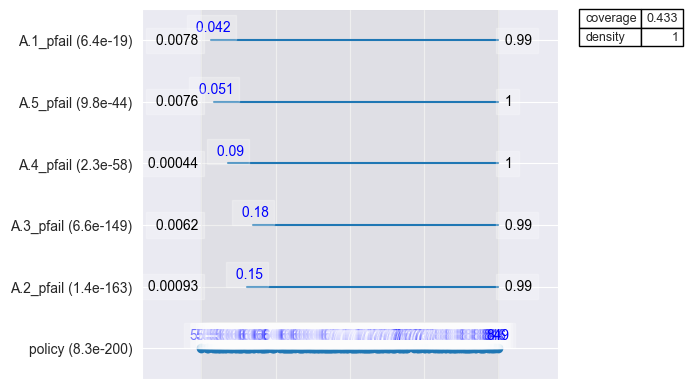

In [50]:
box_expanndamage.inspect()
box_expanndamage.inspect(style='graph')
plt.show()

In [51]:
x = cleaned_experiments.reset_index(drop=True)
# Boolean array van experimenten in de box
in_box_expanndamage = box_expanndamage.yi  # Deze is altijd even lang als x na reset_index

# Selecteer de experimenten die in de box vallen
experiments_in_box_expanndamage = x.loc[in_box_expanndamage]

# Unieke policies selecteren
robust_policies_expanndamage = experiments_in_box_expanndamage['policy'].unique()

# Robuuste policies opzoeken in originele experimenten
robust_policies_df_expanndamage = experiments[experiments['policy'].isin(robust_policies_expanndamage)].drop_duplicates(subset='policy')

# Toon resultaat
print("Robust Policies for Expected annual damage:")
display(robust_policies_df_expanndamage)

Robust Policies for Expected annual damage:


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,6,5,6,3,4,1,3,850,575,dikesnet
500,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,5,3,3,10,3,9,4,850,580,dikesnet
600,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,2,9,7,7,5,10,2,850,581,dikesnet
1100,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,7,6,4,0,10,0,4,850,586,dikesnet
1300,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,1,5,7,3,0,8,1,850,588,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26600,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,3,6,1,8,2,3,2,850,841,dikesnet
26800,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,0,0,3,2,9,1,3,850,843,dikesnet
26900,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,3,0,1,4,9,8,1,850,844,dikesnet
27100,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,9,6,7,7,0,9,4,850,846,dikesnet


In [12]:
# Maak een samengestelde outcome "All Costs" aan door de drie relevante outcomes op te tellen
# Zorg ervoor dat deze keys bestaan in je outcomes dictionary
all_costs = (
    outcomes["RfR Total Costs"] +
    outcomes["Dike Investment Costs"] +
    outcomes["Expected Annual Damage"]
)

# Voeg "All Costs" toe aan de outcomes dictionary voor verdere analyse
outcomes["All Costs"] = all_costs


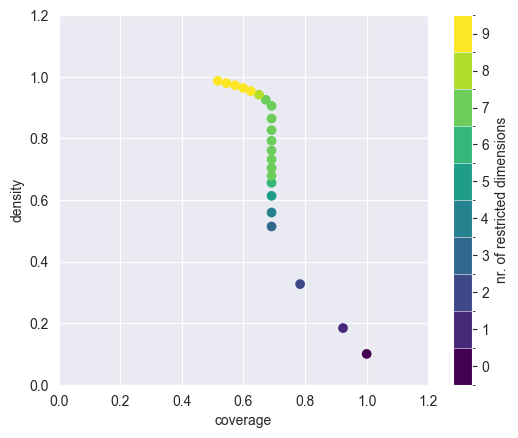

In [13]:
from ema_workbench.analysis import prim
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Vermijd Pandas dtype warning
warnings.filterwarnings("ignore", category=FutureWarning)

# Stel vulnerability condition in
data_allcost = outcomes["All Costs"]
y_allcost = (data_allcost < np.percentile(data_allcost, 10)).astype(int)

# Voer PRIM uit
prim_alg_allcost = prim.Prim(experiments, y_allcost, threshold=0.8)
box_allcost = prim_alg_allcost.find_box()
box_allcost.show_tradeoff()
plt.show()

coverage       0.516727
density        0.986806
id            21.000000
k           1421.000000
mass           0.052364
mean           0.986806
n           1440.000000
res_dim        9.000000
Name: 21, dtype: float64

                                                               box 21  \
                                                                  min   
1_RfR 0                                                           0.0   
1_RfR 2                                                           0.0   
4_RfR 2                                                           0.0   
policy              {575, 576, 577, 578, 579, 580, 581, 582, 583, ...   
A.2_DikeIncrease 0                                                  1   
A.3_DikeIncrease 0                                                  1   
A.1_DikeIncrease 2                                                  1   
A.3_pfail                                                    0.111257   
A.1_pfail                                           

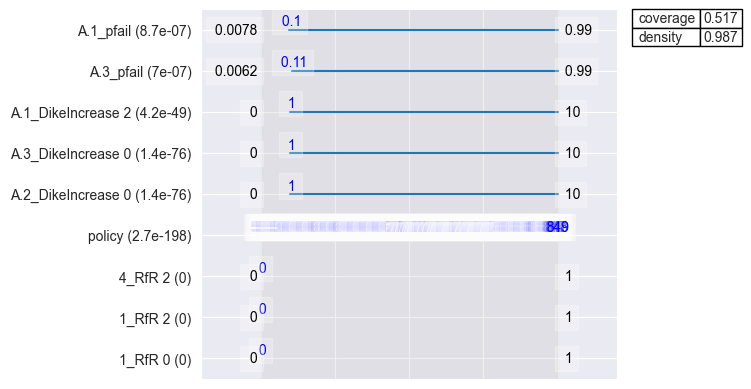

In [14]:
box_allcost.inspect()
box_allcost.inspect(style='graph')
plt.show()

In [15]:
x = cleaned_experiments.reset_index(drop=True)
# Boolean array van experimenten in de box
in_box_allcost = box_allcost.yi  # Deze is altijd even lang als x na reset_index

# Selecteer de experimenten die in de box vallen
experiments_in_box_allcost = x.loc[in_box_allcost]

# Unieke policies selecteren
robust_policies_allcost = experiments_in_box_allcost['policy'].unique()

# Robuuste policies opzoeken in originele experimenten
robust_policies_df_allcost = experiments[experiments['policy'].isin(robust_policies_allcost)].drop_duplicates(subset='policy')

# Toon resultaat
print("Robust Policies for Expected annual damage:")
display(robust_policies_df_allcost)

Robust Policies for Expected annual damage:


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
800,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,5,7,3,1,1,4,0,850,583,dikesnet
3700,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,9,5,1,10,1,8,4,850,612,dikesnet
7400,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,2,6,0,2,7,4,0,850,649,dikesnet
8800,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,0,0,9,0,6,7,2,850,663,dikesnet
9500,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,0,4,9,6,7,8,4,850,670,dikesnet
9700,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,4,7,0,6,10,9,0,850,672,dikesnet
10500,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,2,1,5,9,6,4,4,850,680,dikesnet
11200,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,9,7,8,10,10,7,0,850,687,dikesnet
11800,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,8,1,1,9,7,0,4,850,693,dikesnet
12900,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,5,1,10,10,3,5,0,850,704,dikesnet


In [20]:
# Stap 1: Extract de unieke policy-namen per outcome
set_rfr = set(robust_policies_df_rfrtotalcost['policy'])
set_damage = set(robust_policies_df_expanndamage['policy'])
set_allcost = set(robust_policies_df_allcost['policy'])

# Stap 2: Vind de intersectie (policies die in alle drie voorkomen)
robust_policies_all = set_rfr & set_damage & set_allcost

# Stap 3: Filter originele experimenten op deze policies
robust_policies_df_all = experiments[experiments['policy'].isin(robust_policies_all)].drop_duplicates(subset='policy')

# Stap 4: Toon resultaat
print("Robust Policies for ALL outcomes (intersection of all PRIM analyses):")
display(robust_policies_df_all)


Robust Policies for ALL outcomes (intersection of all PRIM analyses):


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
3700,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,9,5,1,10,1,8,4,850,612,dikesnet
8800,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,0,0,9,0,6,7,2,850,663,dikesnet
9500,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,0,4,9,6,7,8,4,850,670,dikesnet
9700,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,4,7,0,6,10,9,0,850,672,dikesnet
10500,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,2,1,5,9,6,4,4,850,680,dikesnet
11800,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,8,1,1,9,7,0,4,850,693,dikesnet
12900,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,5,1,10,10,3,5,0,850,704,dikesnet
13700,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,5,10,3,4,8,10,1,850,712,dikesnet
15600,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,1,1,7,7,6,1,1,850,731,dikesnet
20200,77,316.974632,1.0,0.980268,301.263656,1.0,0.630832,257.618221,1.5,0.318394,...,6,10,10,6,9,5,0,850,777,dikesnet


DIT KAN DENK IK WEG. HIER MOET DAN EIGEN TEKST MET UITLEG>

This figure shows the trade-off between coverage, density, and the number of restricted dimensions (i.e., a proxy for interpretability). Each dot corresponds to one candidate box. As an analyst, it is up to you to choose which box you want to inspect in more detail. Here you have to balance the three objectives. There is no hard rule that is used here. Note, however, that a density of lower than 0.5 means that less than half of the cases within the box of interest are of interest. So ideally, you start with higher density boxes. Moreover, you want boxes for which the box limits are statistically significant according to the quasi p-values. This means that the last box for a given number of restricted dimensions is also a good candidate box to inspect (here, for example, the last box with 2 dimensions and the last box with 3 dimensions).

This figure shows in gray the complete interval for each parameter. A blue line is used in the case of RealParameters to show the interval of the box identified by PRIM. For CategoricalParameters, a dot is used instead. The blue numbers give the specific limit. The numbers behind the y-labels indicate the quasi p-values. In the top right-hand corner, you can see the coverage and density of the identified box. So, what do we see in this case. First, both delta and stdev are not significant and should be ignored in the interpretation. This leaves b, q, and some of the policies as the key determinants. So, our top 10% worst performance for reliability occurs if b and q are low and for 6 out of the 10 policies. This covers 56% of the cases of interest, with a precision (i.e. density) of 80%. Now, you would go back to the model and try to understand why you get low reliability if b and q are low.

## 2. Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

In [16]:
from ema_workbench.analysis import dimensional_stacking

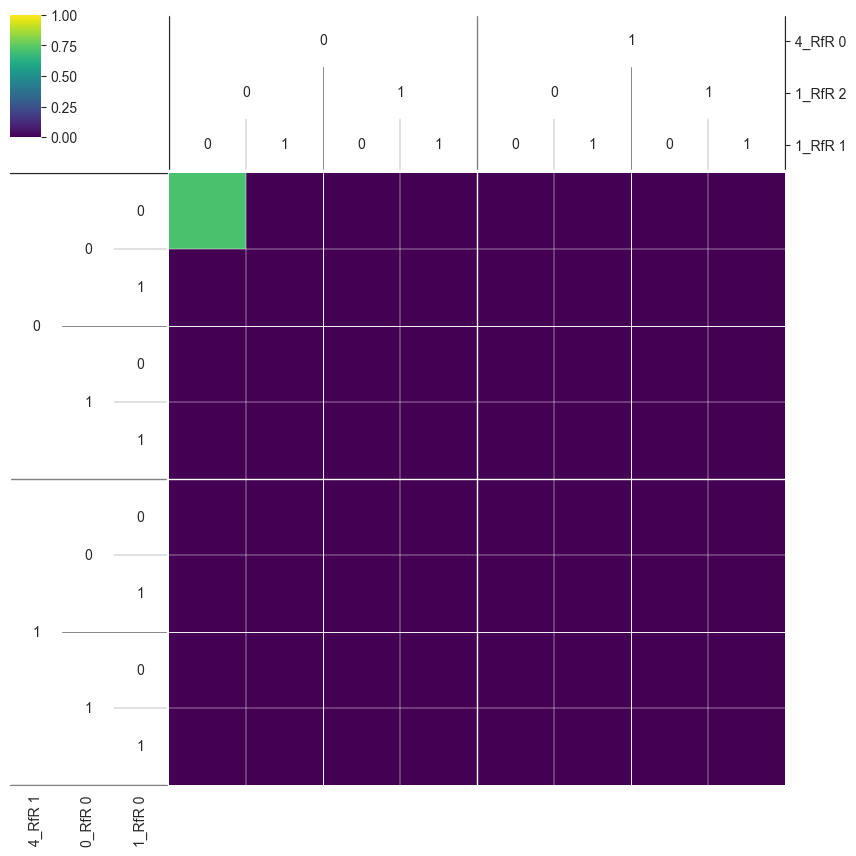

In [17]:
dimensional_stacking.create_pivot_plot(experiments, y_rfrtotalcost)
plt.show()

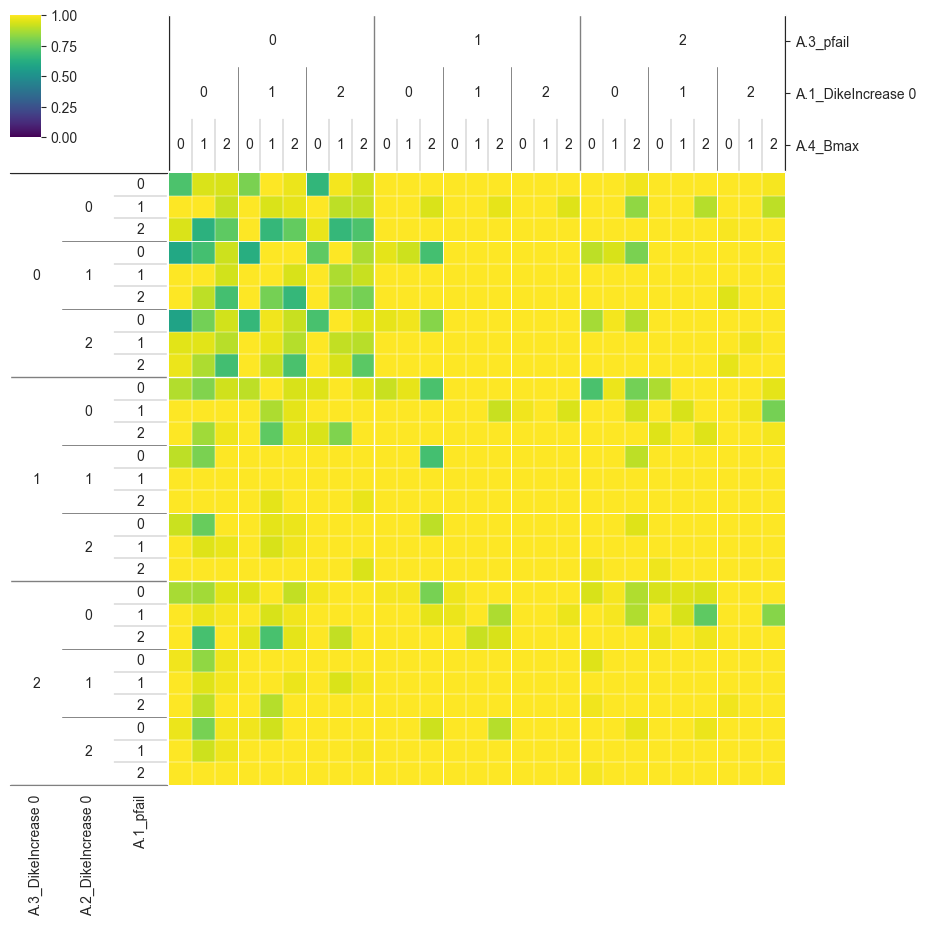

In [18]:
dimensional_stacking.create_pivot_plot(experiments,y_expanndamage)
plt.show()

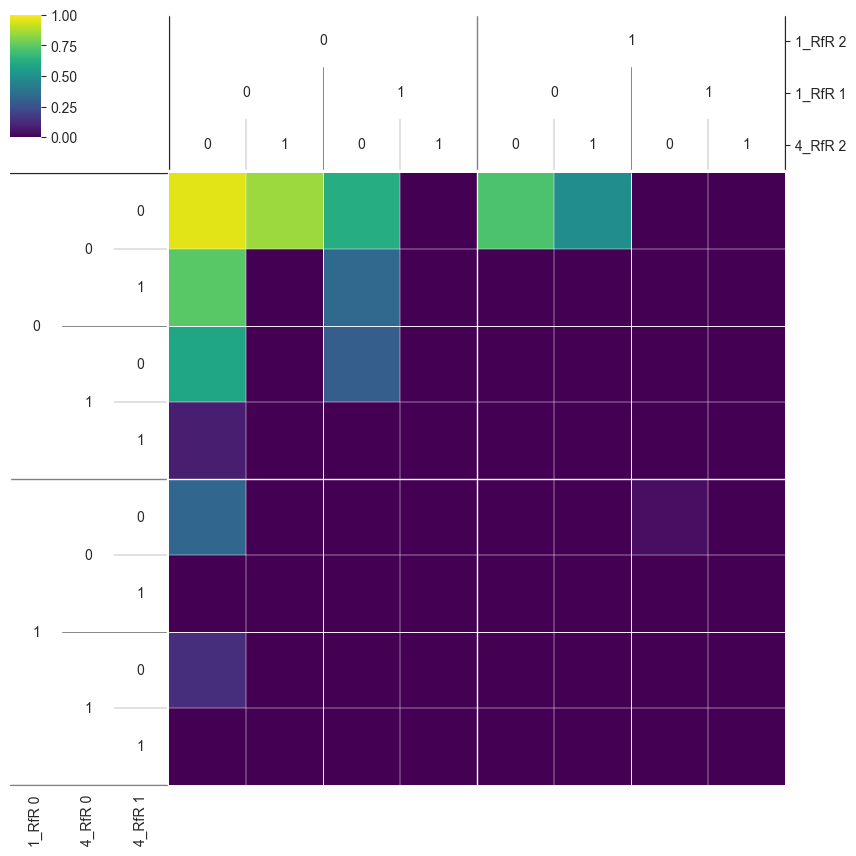

In [19]:
dimensional_stacking.create_pivot_plot(experiments,y_allcost)
plt.show()


DIT KAN WRS WEG. EIGEN TEKST HIER

As you can see, with the additional runs there are at least no white spaces left anymore. This is a good indication that we have a good coverage of the space.

#### Concluding remarks
In this notebook, we have applied several techniques for scenario discovery to the inter temporal version of the lake problem (i.e., the one with 100 decision variables). Both dimensional stacking and PRIM point to the importance of low values for the b and q parameters in driving low reliability. The last, qualitative, step is to go back to the model and offer a structural explanation (remember from system dynamics: structure explains behavior) for this behavior. So why do you get low reliability of b and q are low?